<a href="https://colab.research.google.com/github/maticvl/dataHacker/blob/master/3DFACEMODELING/3D_PCA_cubes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

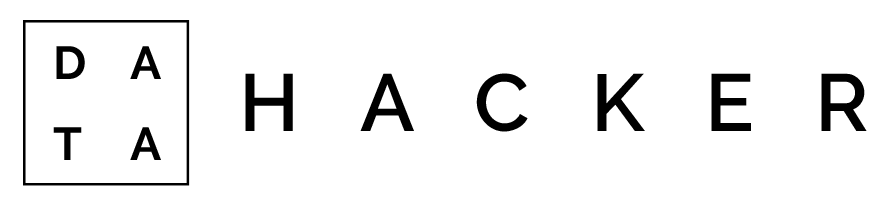
# 3D Model fitting on cube

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2

# Cube Creation

In [54]:
n = 100 # Number of 3D cubes to be generated
RED = (0, 0, 255) # RED COLOR
scale = 50        # Scale the cube on the cv2 canvas
BLACK = (0, 0, 0) # BLACK COLOR

WIDTH = 1920      # Width of the canvas
HEIGHT = 1080     # Height of the canvas
circle_pos = [WIDTH//2, HEIGHT//2] # Center of canvas

In [55]:
average_cubes = np.zeros((n, 8, 3))
for i in range(n):
    delta_shape = np.random.uniform(2, 5)
    points = np.array([ [-1, -1, 1],
                        [1, -1, 1],
                        [1, 1, 1],
                        [-1, 1, 1],
                        [-1, -1, -1],
                        [1, -1, -1],
                        [1, 1, -1],
                        [-1, 1, -1]], dtype=np.float64)
    points *= delta_shape
    average_cubes[i] = points

In [56]:
# Create long cubes | Stretched out
long_cubes = np.zeros((n, 8, 3))
for i in range(n):
    delta_shape = np.random.uniform(2, 5)
    points = np.array([ [-0.5, -0.5, 2],
                        [0.5, -0.5, 2],
                        [0.5, 0.5, 2],
                        [-0.5, 0.5, 2],
                        [-0.5, -0.5, -2],
                        [0.5, -0.5, -2],
                        [0.5, 0.5, -2],
                        [-0.5, 0.5, -2]], dtype=np.float64)

    points *= delta_shape
    long_cubes[i] = points

In [57]:
# Create short cubes | Squished
short_cubes = np.zeros((n, 8, 3))
for i in range(n):
    delta_shape = np.random.uniform(2, 5)
    points = np.array([ [-1, -1, 0.5],
                        [1, -1, 0.5],
                        [1, 1, 0.5],
                        [-1, 1, 0.5],
                        [-1, -1, -0.5],
                        [1, -1, -0.5],
                        [1, 1, -0.5],
                        [-1, 1, -0.5]], dtype=np.float64)

    points *= delta_shape
    short_cubes[i] = points

# PCA

In [58]:
# Concatenate them to form a single vector of size n x 24
X = np.concatenate([average_cubes.reshape(
    n, -1), long_cubes.reshape(n, -1), short_cubes.reshape(n, -1)], 0)

In [59]:
# Create a PCA object and fit on the data
pca = PCA(n_components=24)
pca.fit(X)

PCA(n_components=24)

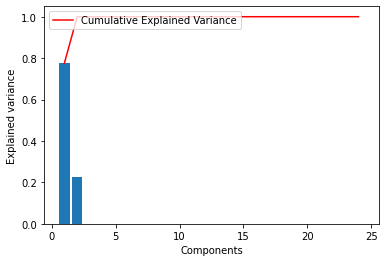

In [60]:
# Understanding how many components we should keep
plt.figure()
plt.bar(range(1, len(pca.explained_variance_ratio_)+1),
        pca.explained_variance_ratio_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot( range(1, len(pca.explained_variance_ratio_)+1),
            np.cumsum(pca.explained_variance_ratio_),
            c='red',
            label="Cumulative Explained Variance")

plt.legend(loc='upper left')
plt.show()

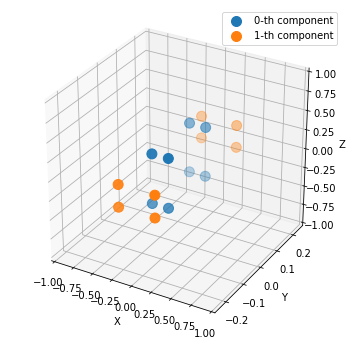

In [61]:
# Understanding the PCA components
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
for i in range(2):
    comp1_x = pca.components_[i, 0:24:3]
    comp1_y = pca.components_[i, 1:24:3]
    comp1_z = pca.components_[i, 2:24:3]
    ax.scatter(comp1_x, comp1_y, comp1_z, s=100, label=f"{i}-th component")
    ax.legend(f"{i}")

ax.set_xlim([-1, 1])
ax.set_xlim([-1, 1])
ax.set_zlim([-1, 1])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

# 3D to 2D Projection

In [62]:
projection_matrix = np.matrix([
    [1, 0, 0],
    [0, 1, 0]
])

projected_points = [
    [n, n] for n in range(len(points))
]

def connect_points(screen, i, j, points):
    cv2.line(screen, (points[i][0], points[i][1]),
            (points[j][0], points[j][1]), BLACK, 1)
    return screen

In [63]:
angle_x = angle_y = angle_z = 0
angle_x += 0.0
angle_y += 0.0
angle_z += np.random.uniform(-0.5, 0.5)

rotation_z = np.matrix([
    [np.cos(angle_z), -np.sin(angle_z), 0],
    [np.sin(angle_z),  np.cos(angle_z), 0],
    [0,                 0,        1],
])

rotation_y = np.matrix([
    [np.cos(angle_y), 0, np.sin(angle_y)],
    [0,         1,        0],
    [-np.sin(angle_y), 0, np.cos(angle_y)],
])

rotation_x = np.matrix([
    [1,       0,                0],
    [0, np.cos(angle_x), -np.sin(angle_x)],
    [0, np.sin(angle_x),  np.cos(angle_x)],
])

In [64]:
front_side = [4, 5, 6, 7]
top_side = [4, 0, 1, 5]
right_side = [5, 6, 2, 1]

In [65]:
screen = np.ones((HEIGHT, WIDTH, 3), dtype=np.uint8) * 255

i = 0
points = X[0].reshape(8, 3)
for point in points:
    rotated3d = np.matmul(rotation_z, point.reshape((3, 1)))
    rotated3d = np.matmul(rotation_y, rotated3d)
    rotated3d = np.matmul(rotation_x, rotated3d)

    projected2d = np.matmul(projection_matrix, rotated3d)

    x = int(projected2d[0][0] * scale) + circle_pos[0]
    y = int(projected2d[1][0] * scale) + circle_pos[1]

    projected_points[i] = [x, y]
    i += 1

cv2.fillPoly(screen, [np.array(projected_points)[front_side]], (0, 0, 255))
cv2.fillPoly(screen, [np.array(projected_points)
            [top_side]], (240, 240, 240))
cv2.fillPoly(screen, [np.array(projected_points)[right_side]], (0, 255, 0))

cv2.polylines(screen, [np.array(projected_points)
            [front_side]], True, (0, 0, 0))
cv2.polylines(screen, [np.array(projected_points)
            [top_side]], True, (0, 0, 0))
cv2.polylines(screen, [np.array(projected_points)
            [right_side]], True, (0, 0, 0))

gray = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray, 4, 0.02, 20)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(screen, (x, y), 40, (0, 0, 0), -1)

In [66]:
out = cv2.VideoWriter(f"projection_and_rotation.mp4", cv2.VideoWriter_fourcc(
    *"mp4v"), 1, (WIDTH, HEIGHT))

all_projected_points = []
all_corners = []
for cube in range(n*3):
    angle_x = angle_y = angle_z = 0

    angle_x += 0.0
    angle_y += 0.0
    angle_z += np.random.uniform(-0.5, 0.5)

    rotation_z = np.matrix([
        [np.cos(angle_z), -np.sin(angle_z), 0],
        [np.sin(angle_z),  np.cos(angle_z), 0],
        [0,                 0,        1],
    ])

    rotation_y = np.matrix([
        [np.cos(angle_y), 0, np.sin(angle_y)],
        [0,         1,        0],
        [-np.sin(angle_y), 0, np.cos(angle_y)],
    ])

    rotation_x = np.matrix([
        [1,       0,                0],
        [0, np.cos(angle_x), -np.sin(angle_x)],
        [0, np.sin(angle_x),  np.cos(angle_x)],
    ])
    screen = np.ones((HEIGHT, WIDTH, 3), dtype=np.uint8) * 255

    i = 0
    points = X[0].reshape(8, 3)
    for point in points:
        rotated3d = np.matmul(rotation_z, point.reshape((3, 1)))
        rotated3d = np.matmul(rotation_y, rotated3d)
        rotated3d = np.matmul(rotation_x, rotated3d)

        projected2d = np.matmul(projection_matrix, rotated3d)

        x = int(projected2d[0][0] * scale) + circle_pos[0]
        y = int(projected2d[1][0] * scale) + circle_pos[1]

        projected_points[i] = [x, y]
        i += 1

    cv2.fillPoly(screen, [np.array(projected_points)[front_side]], (0, 0, 255))
    cv2.fillPoly(screen, [np.array(projected_points)
                [top_side]], (240, 240, 240))
    cv2.fillPoly(screen, [np.array(projected_points)[right_side]], (0, 255, 0))

    cv2.polylines(screen, [np.array(projected_points)
                [front_side]], True, (0, 0, 0))
    cv2.polylines(screen, [np.array(projected_points)
                [top_side]], True, (0, 0, 0))
    cv2.polylines(screen, [np.array(projected_points)
                [right_side]], True, (0, 0, 0))

    gray = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)

    corners = cv2.goodFeaturesToTrack(gray, 4, 0.02, 20)
    corners = np.int0(corners)

    for i in corners:
        x, y = i.ravel()
        cv2.circle(screen, (x, y), 40, (0, 0, 0), -1)

    all_projected_points.append(projected_points)
    all_corners.append(corners)
    out.write(screen)
out.release()

# Model Fitting

In [84]:
alph_1 = np.random.rand(1)
alph_2 = np.random.rand(1)
theta = np.random.rand(1)

lr = 1e-4

pc_components = pca.components_
gt_v = all_corners[0].reshape(4, 2)

In [85]:
thetas = []
alphas1 = []
alphas2 = []
gt_v = all_corners[0].reshape(4, 2)
for _ in range(4000):
    transformed_3d = (
        alph_1 * pc_components[0].reshape(8, 3)) + (alph_2 * pc_components[1].reshape(8, 3))
    rotation_z = np.matrix([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,                 0,          1],
    ])

    rotation_y = np.matrix([
        [np.cos(0),  0, np.sin(0)],
        [0,          1,         0],
        [-np.sin(0), 0, np.cos(0)],
    ])

    rotation_x = np.matrix([
        [1,       0,            0],
        [0, np.cos(0), -np.sin(0)],
        [0, np.sin(0),  np.cos(0)],
    ])

    pr_v = np.zeros((8, 2))
    for i, point in enumerate(transformed_3d):
        rotated_z = np.matmul(rotation_z, point.reshape((3, 1)))
        rotated_y = np.matmul(rotation_y, rotated_z)
        rotated_x = np.matmul(rotation_x, rotated_y)
        projected2d = np.matmul(projection_matrix, rotated_x)
        x = int(projected2d[0][0] * scale) + circle_pos[0]
        y = int(projected2d[1][0] * scale) + circle_pos[1]

        pr_v[i] = [x, y]

    front_side = [4, 5, 6, 7]
    pr_v = pr_v[front_side].astype(np.int64)
    transformed_3d_front = transformed_3d[front_side]

    dif_thetas = []
    dif_alphas1 = []
    dif_alphas2 = []
    for point in range(len(gt_v)):
        gt_x = gt_v[point][0]
        gt_y = gt_v[point][1]
        pr_x = pr_v[point][0]
        pr_y = pr_v[point][1]
        transformed_3d_v = transformed_3d_front[point]
        pc_component0 = pc_components[0].reshape(8, 3)[point]
        pc_component1 = pc_components[1].reshape(8, 3)[point]
        E_landmarks = np.square(gt_x - pr_x) + np.square(gt_y - pr_y)

        dif_theta = 2 * (gt_x - pr_x) * \
            (-1) * \
            (-np.sin(theta) * transformed_3d_v[0] - np.cos(theta) * transformed_3d_v[1]) + \
            2 * (gt_y - pr_y) * \
            (-1) * \
            (np.cos(theta) *
             transformed_3d_v[0] + np.sin(theta) * transformed_3d_v[1])

        dif_alpha_1 = 2 * (gt_x - pr_x) * \
            (np.cos(theta) * pc_component0[0] - np.sin(theta) * pc_component0[1]) * \
            (-1) + \
            2 * (gt_y - pr_y) * \
            (np.sin(theta) * pc_component0[0] + np.cos(theta) * pc_component0[1]) * \
            (-1)

        dif_alpha_2 = 2 * (gt_x - pr_x) * \
            (np.cos(theta) * pc_component1[0] - np.sin(theta) * pc_component1[1]) * \
            (-1) + \
            2 * (gt_y - pr_y) * \
            (np.sin(theta) * pc_component1[0] + np.cos(theta) * pc_component1[1]) * \
            (-1)

        dif_thetas.append(dif_theta)
        dif_alphas1.append(dif_alpha_1)
        dif_alphas2.append(dif_alpha_2)

    theta  -= lr * (np.mean(dif_thetas) )
    alph_1 -= lr * (np.mean(dif_alphas1))
    alph_2 -= lr * (np.mean(dif_alphas2))

    thetas.append(theta[0].copy())
    alphas1.append(alph_1[0].copy())
    alphas2.append(alph_2[0].copy())

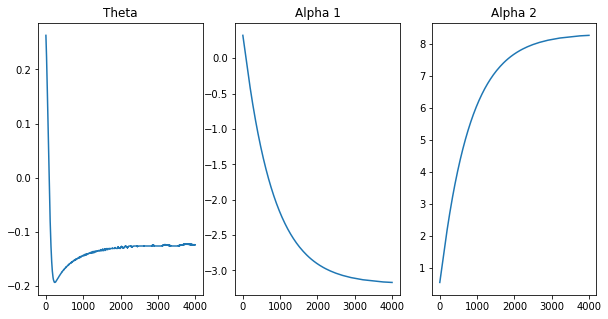

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].set_title("Theta")
axs[0].plot(thetas)

axs[1].set_title("Alpha 1")
axs[1].plot(alphas1)

axs[2].set_title("Alpha 2")
axs[2].plot(alphas2)
plt.show()